# Preliminaries

## Importing Libraries

In [1]:
from catboost import CatBoostClassifier
import joblib
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Configuration

In [3]:
class Config:
    DATASET_PATH = '../data/titanic.csv'
    LABEL_COLUMN = 'Survived'
    SPLIT_RATIO=0.25
    RANDOM_SEED=420
    NUMERIC_COL_DTYPES = ['int', 'float']
    IDENTIFIER = 'titanic'

## Loading Dataset

In [4]:
X = pd.read_csv(Config.DATASET_PATH)
X, y = X.drop(columns=[Config.LABEL_COLUMN]), X[Config.LABEL_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=Config.SPLIT_RATIO, random_state=Config.RANDOM_SEED, stratify=y)
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
28,29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
728,729,2,"Bryhl, Mr. Kurt Arnold Gottfrid",male,25.0,1,0,236853,26.0000,NaN,S
291,292,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,C
358,359,3,"McGovern, Miss. Mary",female,NaN,0,0,330931,7.8792,NaN,Q
556,557,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C


# Analysis

## Info

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 28 to 235
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  668 non-null    int64  
 1   Pclass       668 non-null    int64  
 2   Name         668 non-null    object 
 3   Sex          668 non-null    object 
 4   Age          527 non-null    float64
 5   SibSp        668 non-null    int64  
 6   Parch        668 non-null    int64  
 7   Ticket       668 non-null    object 
 8   Fare         668 non-null    float64
 9   Cabin        163 non-null    object 
 10  Embarked     666 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 62.6+ KB


- Might just drop `Cabin`
- Would need to fill in the age with median or mean.
- Would fill in the 2 missing embarked as well with mode.
- Might drop `Name` and `PassengerId` columns. `Name` will not be easy to make work.
- `Ticket` also seems droppable.

## Columns Separation

In [6]:
cols_to_drop = ['Cabin', 'Name', 'PassengerId', 'Ticket']
cols_to_keep = [col for col in list(X_train.columns) if col not in cols_to_drop]

numeric_cols = X_train.select_dtypes(include=Config.NUMERIC_COL_DTYPES).columns
numeric_cols = [col for col in numeric_cols if col in cols_to_keep]

non_numeric_cols = X_train.select_dtypes(exclude=Config.NUMERIC_COL_DTYPES).columns
non_numeric_cols = [col for col in non_numeric_cols if col in cols_to_keep]

## Data Imputation

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', SimpleImputer(strategy='most_frequent'), non_numeric_cols),
    ],
    remainder='drop'
)

preprocessor.fit(X_train)
X_train = pd.DataFrame(preprocessor.transform(X_train), columns=numeric_cols+non_numeric_cols, index=X_train.index)

## Plots

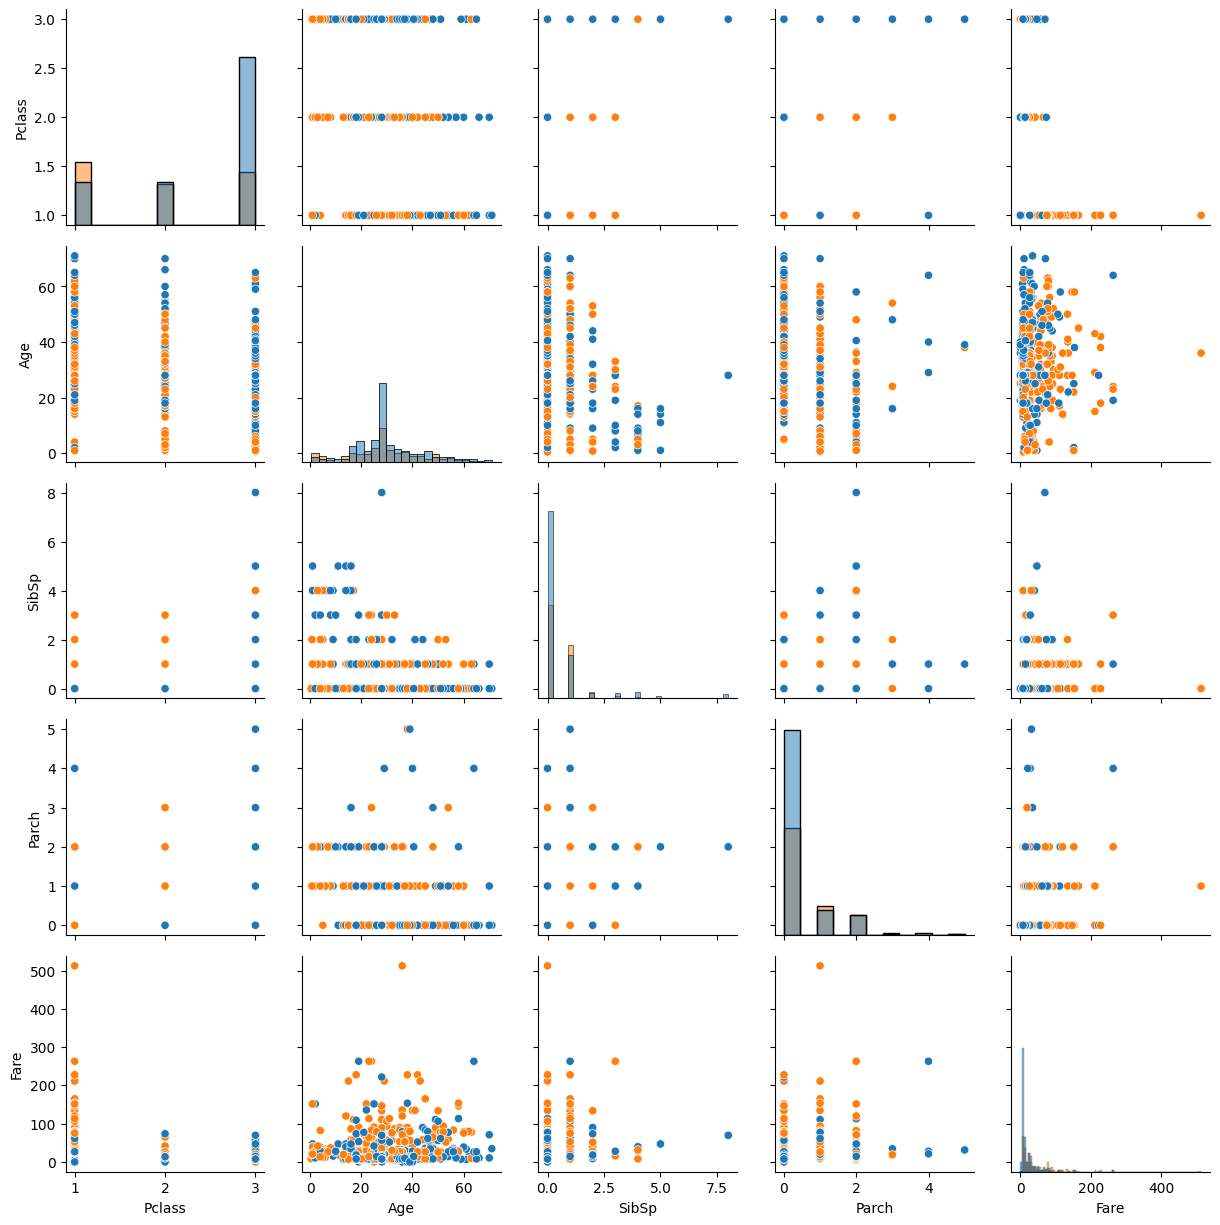

In [8]:
g = sns.PairGrid(pd.concat([X_train, y_train], axis=1), hue='Survived')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

# Preprocess

In [9]:
class RemoveStringColumnsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        numeric_columns_mask = np.array([np.issubdtype(type(val), np.number) for val in X[0]])
        numeric_data = X[:, numeric_columns_mask]
        
        return numeric_data

final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', SimpleImputer(strategy='most_frequent'), non_numeric_cols),
        ('ord', OrdinalEncoder(categories=[['male', 'female']]), ['Sex']),
        ('ohe', OneHotEncoder(), ['Embarked']),
    ],
    remainder='drop'
)

preprocessor_pipeline = Pipeline(
    steps=[
        ('col', final_preprocessor),
        ('sct', RemoveStringColumnsTransformer()),
        ('std', StandardScaler())
    ]
)

preprocessor_pipeline

Pipeline(steps=[('col',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Sex', 'Embarked']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['male',
                                                                              'female']]),
                                                  ['Sex']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Embarked'])])),
                ('sct', RemoveStringColumnsTransformer()),
                ('std', StandardScaler())])

# Model

In [10]:

models_search = [
    ('knn', KNeighborsClassifier(), {'n_neighbors': [2, 3, 5, 7, 11], 'p': [1, 2, 3, 4]}),
    ('xgb', XGBClassifier(objective='binary:logistic'), {
        'max_depth': range(2, 10, 1), 'n_estimators': range(60, 220, 40), 'learning_rate': [0.1, 0.01, 0.05, 0.03]
    }),
    ('cat', CatBoostClassifier(silent=True), {'learning_rate': [0.01, 0.05, 0.1], 'depth': [4, 6, 8, 10], 'n_estimators': [50, 100, 200]}),
    ('lgb', LGBMClassifier(verbose=-1), {
        'learning_rate': [0.1, 0.03, 0.05, 0.3], 'num_leaves': [-1, 50, 100, 200], 'n_estimators': [50, 100, 200]
    }),
]

# The best one was lgb with params: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 50 }

'''
for model_name, model, params in models_search:
    pipeline = Pipeline(
        steps=[
            ('col', preprocessor_pipeline),
            ('clf', GridSearchCV(model, params))
        ]
    )
    pipeline.fit(X_train, y_train)
    clf_predictions = pipeline.predict(X_test)
'''

final_pipeline = Pipeline(
    steps=[
        ('col', preprocessor_pipeline),
        ('clf', LGBMClassifier(verbose=-1, learning_rate=0.1, num_leaves=50, n_estimators=50))
    ]
)
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('col',
                 Pipeline(steps=[('col',
                                  ColumnTransformer(transformers=[('num',
                                                                   SimpleImputer(strategy='median'),
                                                                   ['Pclass',
                                                                    'Age',
                                                                    'SibSp',
                                                                    'Parch',
                                                                    'Fare']),
                                                                  ('cat',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['Sex',
                                                                    'Embarked']),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['male',
                                                                                               'female']]),
                                                                   ['Sex']),
                                                                  ('ohe',
                                                                   OneHotEncoder(),
                                                                   ['Embarked'])])),
                                 ('sct', RemoveStringColumnsTransformer()),
                                 ('std', StandardScaler())])),
                ('clf',
                 LGBMClassifier(n_estimators=50, num_leaves=50, verbose=-1))])

In [11]:
accuracy_score(final_pipeline.predict(X_test), y_test)

0.820627802690583

# Export

In [12]:
joblib.dump(final_pipeline, f'../assets/ml_models/titanic/{Config.IDENTIFIER}.pkl')

['../assets/ml_models/titanic/titanic.pkl']